In [2]:
!jupyter nbconvert --to python ./sentinel2-sattelite-images-classification-solution-design-WIP.ipynb

[NbConvertApp] Converting notebook ./sentinel2-sattelite-images-classification-solution-design-WIP.ipynb to python
[NbConvertApp] Writing 11146 bytes to ./sentinel2-sattelite-images-classification-solution-design-WIP.py


## Data input types

In [4]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

def extract_table(wiki_page, header_row=0):
    soup = BeautifulSoup(requests.get(wiki_page).text, "html5lib")
    table = soup.find("table")
    rows = table.find_all("tr")

    header = [re.sub(r'(\[\d\])', '', x.text) for x in rows[header_row].find_all('th')]
    table = [[x.text for x in row.find_all('td')] for row in rows[header_row+1:]]
    return pd.DataFrame(table, columns=header)

In [5]:
page = 'https://gisgeography.com/how-to-download-sentinel-satellite-data'
wavelength_bands = extract_table(page, header_row=0)
wavelength_bands

,Band,Resolution,Central Wavelength,Description
0,B1,60 m,443 nm,Ultra blue (Coastal and Aerosol)
1,B2,10 m,490 nm,Blue
2,B3,10 m,560 nm,Green
3,B4,10 m,665 nm,Red
4,B5,20 m,705 nm,Visible and Near Infrared (VNIR)
5,B6,20 m,740 nm,Visible and Near Infrared (VNIR)
6,B7,20 m,783 nm,Visible and Near Infrared (VNIR)
7,B8,10 m,842 nm,Visible and Near Infrared (VNIR)
8,B8a,20 m,865 nm,Visible and Near Infrared (VNIR)
9,B9,60 m,940 nm,Short Wave Infrared (SWIR)


## Data input

In [141]:
from zipfile import ZipFile
filename = '../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.zip'
filename = '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.zip'
zip_file = ZipFile(filename)

_is_wave_band_img = lambda x: 'B' in x.filename and 'IMG_DATA' in x.filename
band_files = [x for x in zip_file.infolist() if _is_wave_band_img(x)]
zip_file.extractall(members=band_files, path='../data/')

In [ ]:
ll -h ../data/S2B_MSIL1C_20170720T090559_N0205_R050_T33PZK_20170720T092114.SAFE/GRANULE/L1C_T33PZK_A001935_20170720T092114/IMG_DATA/

In [146]:
ll -h ../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/

total 382M
-rw-r--r-- 1 adrian 946K 15 apr 00:18 T33UYP_20180408T095029_AOT_20m.jp2
-rw-r--r-- 1 adrian  33M 15 apr 00:18 T33UYP_20180408T095029_B02_20m.jp2
-rw-r--r-- 1 adrian  33M 15 apr 00:18 T33UYP_20180408T095029_B03_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B04_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B05_20m.jp2
-rw-r--r-- 1 adrian  35M 15 apr 00:18 T33UYP_20180408T095029_B06_20m.jp2
-rw-r--r-- 1 adrian  36M 15 apr 00:18 T33UYP_20180408T095029_B07_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B11_20m.jp2
-rw-r--r-- 1 adrian  34M 15 apr 00:18 T33UYP_20180408T095029_B12_20m.jp2
-rw-r--r-- 1 adrian  36M 15 apr 00:18 T33UYP_20180408T095029_B8A_20m.jp2
-rw-r--r-- 1 adrian 4,9M 15 apr 00:18 T33UYP_20180408T095029_SCL_20m.jp2
-rw-r--r-- 1 adrian  49M 15 apr 00:18 T33UYP_20180408T095029_TCI_20m.jp2
-rw-r--r-- 1 adrian  22M 15 apr 00:18 T33UYP_20180408T095029_WVP_20m.jp2


# Convert images from .jp2 to .tiff format
* [gdal on Anaconda](https://anaconda.org/conda-forge/gdal)

# TODO:
* create own script for processing using gdal_merge.py with suitable arguments and/or similarly gdal_translate.py
* references:
    * [introduction to satellite imaging](https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971)
    * [stack exchange with gdal commands](https://gis.stackexchange.com/questions/257836/raw-sentinel-2-jp2-to-rgb-geotiff)
    * [reflectance values range](https://gis.stackexchange.com/questions/233874/what-is-the-range-of-values-of-sentinel-2-level-2a-images/234044)

# Run script

In [91]:
import os
from glob import glob
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline

files = glob('../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/*')
files = sorted(files)
file_dict = dict(zip(['10m', '20m', '60m'], [sorted(glob(os.path.join(x, '*'))) for x in files]))

In [100]:
import subprocess
import numpy as np

def convert_to_geotiff(input_path, output_path, ot):
    cmd = "gdal_translate -ot {ot} -of GTiff -co TILED=YES {input} {output}"
    cmd = cmd.format(ot=ot, input=input_path, output=output_path)
    return cmd.split(" ")

def get_commands(vrt_file, tif_file, file_list, set_resolution=False, ot='Byte'):
    # Merge bands
    # merge_cmd = "gdalbuildvrt -separate {0} {1}".format(out_vrt_file, " ".join(file_list))
    merge_cmd_list = "gdalbuildvrt -separate".split(" ")
    resolution_cmd_list = "-resolution user -tr 20 20".split(" ")
    if set_resolution: merge_cmd_list += resolution_cmd_list
    vrt_cmd = merge_cmd_list + [vrt_file] + file_list
    # Convert to uncompressed GeoTiff
    # trsl_cmd = "gdal_translate -ot Byte -of GTiff -co TILED=YES {0} {1}".format(out_vrt_file, out_tif_file)
    trsl_cmd_list = convert_to_geotiff(vrt_file, tif_file, ot)
    return vrt_cmd, trsl_cmd_list

def run_command(cmd_list):
    p = subprocess.Popen(cmd_list, stdout=subprocess.PIPE)
    print(p.communicate())
    
def read_tiff(filename):
    tiff_image = tiff.imread(filename)
    print(tiff_image.shape, tiff_image.min(), tiff_image.max())
    return tiff_image

out_path = '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858_PROCESSED/'
if not os.path.exists(out_path):
    os.makedirs(out_path)
out_path = os.path.abspath(out_path)

# RGB bands

In [127]:
out_tci_file = os.path.join(out_path, 'TCI.tif')
in_tci_file = file_dict['20m'][-2]
rgb_cmd_list = convert_to_geotiff(in_tci_file, out_tci_file, ot='Byte')
run_command(rgb_cmd_list)

(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


(5490, 5490, 3) 6 255


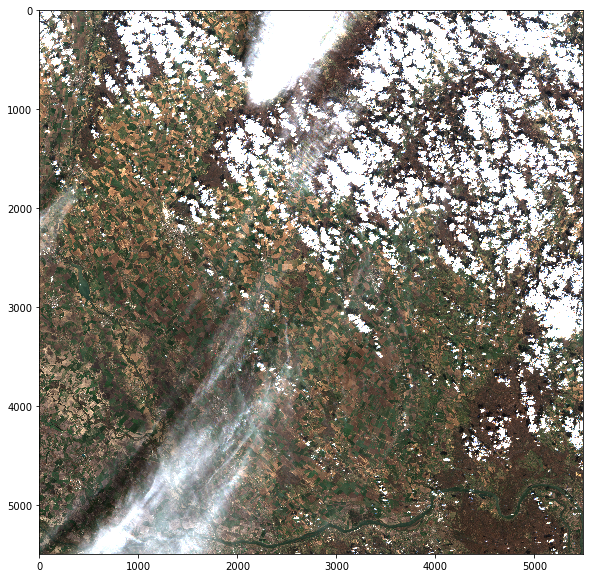

In [128]:
tci_tif = read_tiff(out_tci_file)
plt.figure(figsize=[10, 10])
plt.imshow(tci_tif)

# NDVI bands

In [126]:
nvdi_vrt_file = os.path.join(out_path, 'nvdi.vrt')
nvdi_tif_file = os.path.join(out_path, 'nvdi.tif')
nvdi_files = [x for x in file_dict['20m'] if 'B11' in x or 'B8A' in x]
nvdi_cmd_list = get_commands(nvdi_vrt_file, nvdi_tif_file, nvdi_files, ot='Int16', set_resolution=False)

# subprocess.call(nvdi_cmd_list[0])  # merge to vrt
# subprocess.call(nvdi_cmd_list[1])  # convert to tif

run_command(nvdi_cmd_list[0])  # merge to vrt
run_command(nvdi_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [74]:
ndvi_tif = read_tiff(nvdi_tif_file)
# plt.imshow(ndvi_tif)

(5490, 5490, 2) 1 16011


In [98]:
nvdi_files

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/T33UYP_20180408T095029_B11_20m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R20m/T33UYP_20180408T095029_B8A_20m.jp2']

-0.9995705389735882 0.7596668649613325


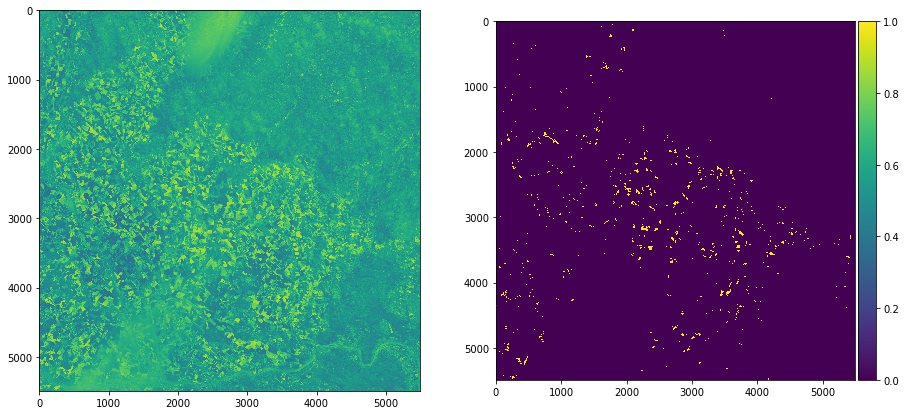

In [124]:
bands = dict(zip(['B8A', 'B11'], [1, 0]))

def calculate_ndvi(image):
    rval = np.divide(image[..., bands['B8A']] - image[..., bands['B11']],
                     image[..., bands['B8A']] + image[..., bands['B11']])
    return np.where(np.isnan(rval), 0., rval)

ndvi = calculate_ndvi(ndvi_tif)
print(ndvi.min(), ndvi.max())
fig, axs = plt.subplots(1, 2, figsize=[15, 10])
axs[0].imshow(ndvi)
img = axs[1].imshow(np.float32(ndvi > 0.5))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax)

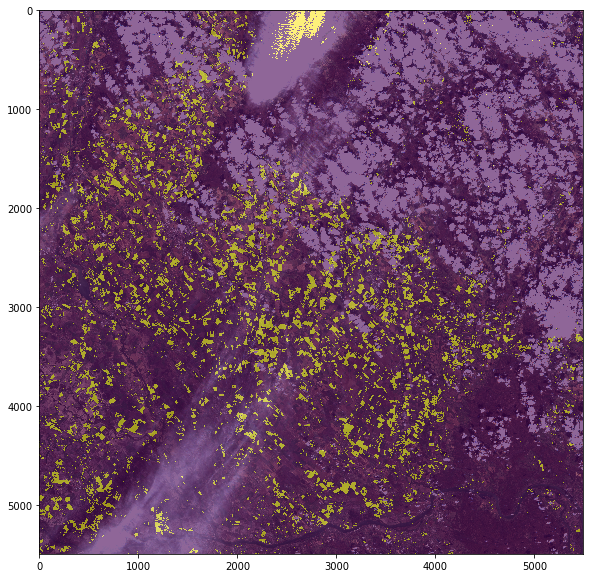

In [119]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.imshow(tci_tif)
ax.imshow(np.float32(ndvi > 0.3), alpha=0.6)

# All bands

In [64]:
all_bands_vrt_file = os.path.join(out_path, "all_bands.vrt")
all_bands_tif_file = os.path.join(out_path, "all_bands.tif")
all_bands_files = [x for x in file_dict['20m'] if 'B0' in x or 'B8A' in x]

In [69]:
all_bands_cmd_list = get_commands(all_bands_vrt_file, all_bands_tif_file, all_bands_files,
                                  ot='Int16', set_resolution=False)
run_command(all_bands_cmd_list[0])  # merge to vrt
run_command(all_bands_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [75]:
all_bands = read_tiff(all_bands_tif_file)

(5490, 5490, 7) 1 18890


In [113]:
[x for x in file_dict['10m'] if 'B0' in x or 'B8A' in x]

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B02_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B03_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B04_10m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R10m/T33UYP_20180408T095029_B08_10m.jp2']

In [112]:
[x for x in file_dict['60m'] if 'B0' in x or 'B8A' in x]

['../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B01_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B02_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B03_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B04_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T095029_B05_60m.jp2',
 '../data/S2B_MSIL2A_20180408T095029_N0207_R079_T33UYP_20180408T115858.SAFE/GRANULE/L2A_T33UYP_A005682_20180408T095239/IMG_DATA/R60m/T33UYP_20180408T0

In [96]:
all_bands_files = [x for x in file_dict['10m'] if 'B0' in x or 'B8A' in x]
all_bands_cmd_list = get_commands(all_bands_vrt_file, all_bands_tif_file, all_bands_files,
                                  ot='Int16', set_resolution=True)
run_command(all_bands_cmd_list[0])  # merge to vrt
run_command(all_bands_cmd_list[1])  # convert to tif

(b'0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)
(b'Input file size is 5490, 5490\n0...10...20...30...40...50...60...70...80...90...100 - done.\n', None)


In [97]:
all_bands = read_tiff(all_bands_tif_file)

(5490, 5490, 9) 1 20700
